In [1]:
import pandas as pd
import numpy as np
import requests
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import os
%load_ext dotenv

C:\Users\Remo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
%dotenv -vo .env

In [3]:
url = ('https://api.eia.gov/v2/electricity/rto/daily-region-sub-ba-data/data/'
       '?frequency=daily'
       '&data[0]=value'
       '&facets[subba][]=ZONJ'
       '&facets[timezone][]=Eastern'
       '&start=2017-01-01'
       '&end=2021-12-31'
       '&sort[0][column]=period'
       '&sort[0][direction]=desc'
       '&offset=0'
       '&length=5000'
       '&api_key=') + os.environ.get('EIA_API_KEY')

In [4]:
data = requests.get(url).json()['response']['data']
data = pd.DataFrame(data)

In [5]:
display(data.head(5))

,period,subba,subba-name,parent,parent-name,timezone,value,value-units
0,2021-12-31,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,117546,megawatthours
1,2021-12-30,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,123116,megawatthours
2,2021-12-29,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,125574,megawatthours
3,2021-12-28,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,125714,megawatthours
4,2021-12-27,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,127916,megawatthours


In [6]:
demand_daily = data[['period', 'value']].rename(columns={'period': 'date', 'value': 'demand'})
demand_daily['date'] = pd.to_datetime(demand_daily['date'], infer_datetime_format=True)
display(demand_daily.head(5))

,date,demand
0,2021-12-31,117546
1,2021-12-30,123116
2,2021-12-29,125574
3,2021-12-28,125714
4,2021-12-27,127916


In [7]:
display(demand_daily.dtypes)

date      datetime64[ns]
demand             int64
dtype: object

In [8]:
# read weather data (dataset years 2017-2021 for LaGuardia from https://www.ncdc.noaa.gov/, daily summaries in climate data online)
weather_data = pd.read_csv('./noaa_weather_lag_2017-2021.csv')
display(weather_data.head(5))

,STATION,NAME,DATE,TAVG
0,USW00014732,"LAGUARDIA AIRPORT, NY US",2017-01-01,8.0
1,USW00014732,"LAGUARDIA AIRPORT, NY US",2017-01-02,4.4
2,USW00014732,"LAGUARDIA AIRPORT, NY US",2017-01-03,5.6
3,USW00014732,"LAGUARDIA AIRPORT, NY US",2017-01-04,8.2
4,USW00014732,"LAGUARDIA AIRPORT, NY US",2017-01-05,1.0


In [9]:
weather_daily = weather_data[['DATE', 'TAVG']].rename(columns={'DATE': 'date', 'TAVG': 'temperature'})
weather_daily['date'] = pd.to_datetime(weather_daily['date'], infer_datetime_format=True)
display(weather_daily.head(5))

,date,temperature
0,2017-01-01,8.0
1,2017-01-02,4.4
2,2017-01-03,5.6
3,2017-01-04,8.2
4,2017-01-05,1.0


In [10]:
display(weather_daily.dtypes)

date           datetime64[ns]
temperature           float64
dtype: object

In [11]:
df = pd.merge(weather_daily, demand_daily, how='inner', on='date')
display(df.head(5))

,date,temperature,demand
0,2018-06-19,28.6,197017
1,2018-06-20,24.7,176885
2,2018-06-21,23.7,175052
3,2018-06-22,22.4,159840
4,2018-06-23,18.5,129943


In [12]:
df['day'] = df['date'].dt.dayofweek
display(df.head(5)) # 0=mon, ..., sun=6

,date,temperature,demand,day
0,2018-06-19,28.6,197017,1
1,2018-06-20,24.7,176885,2
2,2018-06-21,23.7,175052,3
3,2018-06-22,22.4,159840,4
4,2018-06-23,18.5,129943,5


In [13]:
df['month'] = df['date'].dt.month
display(df.head(5)) # 1=jan, ..., dec=12

,date,temperature,demand,day,month
0,2018-06-19,28.6,197017,1,6
1,2018-06-20,24.7,176885,2,6
2,2018-06-21,23.7,175052,3,6
3,2018-06-22,22.4,159840,4,6
4,2018-06-23,18.5,129943,5,6


In [14]:
# add (find) bank holiday (binary mask)
holidays = calendar().holidays(start=df['date'].min(), end=df['date'].max())
df['holiday'] = df['date'].isin(holidays).astype(int)
display(df.head(5))

,date,temperature,demand,day,month,holiday
0,2018-06-19,28.6,197017,1,6,0
1,2018-06-20,24.7,176885,2,6,0
2,2018-06-21,23.7,175052,3,6,0
3,2018-06-22,22.4,159840,4,6,0
4,2018-06-23,18.5,129943,5,6,0


In [ ]:
# TODO: store features (once prepared) somewhere (hopsworks?)

In [ ]:
# TODO: split feature prep from training (below) and store model somewhere once trained (hopsworks or HF?)
# we don't have to repeat all steps done here, CV/Random search used just to find some reasonable parameters for XGB

In [15]:
seed = np.random.RandomState(65)

In [16]:
df_num = df.drop(columns=['date']) # not needed

In [17]:
# training/testing split (for performance estimate)
label = 'demand'
X = df_num.drop(columns=[label])
y = df_num[label]
display(X.head(5))
display(y.head(5))

,temperature,day,month,holiday
0,28.6,1,6,0
1,24.7,2,6,0
2,23.7,3,6,0
3,22.4,4,6,0
4,18.5,5,6,0


0    197017
1    176885
2    175052
3    159840
4    129943
Name: demand, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
display(X_train.head(5))
display(y_train.head(5))
display(X_test.head(5))
display(y_test.head(5))

,temperature,day,month,holiday
632,7.7,3,3,0
256,1.2,5,3,0
124,10.7,6,10,0
529,2.9,5,11,0
558,5.7,6,12,0


632    128016
256    131932
124    114968
529    122415
558    120531
Name: demand, dtype: int64

,temperature,day,month,holiday
76,27.9,0,9,1
848,16.2,2,10,0
866,10.2,6,11,0
1090,20.1,6,6,0
493,15.0,4,10,0


76      187973
848     116042
866     114855
1090    117076
493     125217
Name: demand, dtype: int64

In [19]:
# re-usable data prep pipeline, avoids having info leaks from test splits in cross-validation
# update feature filter if needed
cols = ['temperature']

# TODO: data prep necessary? (probably enough to normalize/discretize temperature)

prepare = Pipeline([
    ('impute', SimpleImputer()), # not needed (for this data) but better safe than sorry
    ('scale', MinMaxScaler()), # [0..1] (not strictly necessary but should handle outliers better)
    # skipping, might have a bit of noise but temps are averaged, so shouldn't be too bad (tests perform well anyway)
    #('discretize', KBinsDiscretizer(n_bins=10, encode='ordinal'))
])

column_trans = ColumnTransformer([
    ('prepare', prepare, cols)],
    remainder='passthrough', # leave other cols as-is
    verbose_feature_names_out=False)

In [20]:
kf = RepeatedKFold(n_splits=10, random_state=seed)

In [21]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=seed) # default metric

xgb_pipeline = Pipeline([
    ('data_prep', column_trans),
    ('xgb', xgb)
]) # data prep defined as pipeline so each CV split is fitted to training split only

params = {
    # TODO: we could parametrize data prep too and test some combinations
    # TODO: check params for search grid
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'xgb__colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
}

In [22]:
gs_xgb = RandomizedSearchCV(xgb_pipeline,
                            random_state=seed,
                            param_distributions=params,
                            cv=kf,
                            verbose=3,
                            n_jobs=-1)

In [23]:
gs_xgb.fit(X_train, y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10,
       random_state=RandomState(MT19937) at 0x1B1E7449E40),
                   estimator=Pipeline(steps=[('data_prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('prepare',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['temperature'])],
                                                                verbose_feature_names_out=False)),
  

In [24]:
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'xgb__min_child_weight': 3,
 'xgb__max_depth': 3,
 'xgb__learning_rate': 0.15,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 0.5}

0.8892473506567569

In [25]:
# get best model
model = gs_xgb.best_estimator_

In [26]:
# get predictions for test set to get a performance estimate for unseen data
# best model is already re-trained on whole training data! (default for refit=True)
y_pred = model.predict(X_test)
err = mean_absolute_error(y_test, y_pred)
display(err) # MWh

5821.528052606178

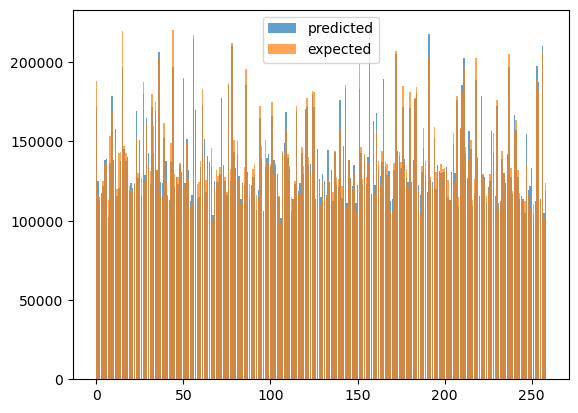

In [27]:
pyplot.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
pyplot.bar(x=np.arange(len(y_pred)), height=y_test.to_numpy(), label='expected', alpha=0.7)
pyplot.legend()
pyplot.show() # this representation doesn't make a lot of sense 🤷‍♂️

In [70]:
# retrain model on whole set
model.fit(X, y) # reminder: "model" contains whole pipeline including data prep!

# TODO: some stuff with the model

Pipeline(steps=[('data_prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('prepare',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('discretize',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10))]),
                                                  ['temperature'])],
                                   verbose_feature_names_out=False)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                  